In [1]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats

import random

# To acquire MYSQL Data
import acquire
from env import user, password, host
import zillow_wrangle
import evaluate

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# To avoid deprecation and other warnings
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
# Data acquired through SQL query to Codeup MYSQL Database and saved locally to csv.
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,77575,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017-09-20,Single Family Residential
77576,77576,261.0,17239384,2968375,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,77610,0.013209,2017-09-21,Single Family Residential
77577,77577,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017-09-21,Single Family Residential
77578,77578,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017-09-25,Single Family Residential


In [3]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    # Create a column that will label our rows as containing an outlier value or not
    num_obs = df.shape[0]
    df['outlier'] = False
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label any time that the value is outside of boundaries
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    df = df[df.outlier == False]
    df.drop(columns=['outlier'], inplace=True)
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
    print('Percentage of original Dataframe removed: {:.2f}'.format((num_obs - df.shape[0])/52441))
    
    return df

In [4]:
def wrangle_zillow(df):
    random.seed(217)
    df = df[(df.propertylandusedesc == 'Single Family Residential') | 
            (df.propertylandusedesc == 'Inferred Single Family Residential')]
    # Create a new column for month of transaction
    df['month'] = df['transactiondate'].str[5:7]
    df['transactiondate'] = df['transactiondate'].str[:4]
    # Reassign the df to only the values where the home had a transaction in 2017
    df = df[df.transactiondate == '2017']
    parcelid = df.parcelid
    df = df.drop(columns={'parcelid'})
    df.rename(columns={'bedroomcnt':'bedrooms',
                       'bathroomcnt':'bathrooms', 
                       'calculatedfinishedsquarefeet':'f_sqft', 
                       'taxvaluedollarcnt':'tax_value',
                       'lotsizesquarefeet':'lot_size',
                       'regionidzip':'zip',
                       'buildingqualitytypeid':'bldg_quality'}, inplace=True)
    
    df = df[['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips',
             'lot_size','rawcensustractandblock', 'zip', 'logerror',
             'yearbuilt', 'structuretaxvaluedollarcnt','tax_value', 
             'landtaxvaluedollarcnt']]#'month', 'numberofstories', 'unitcnt', taxamount, 'latitude', 'longitude'
    
    cols = [col for col in df.columns if col not in ['month', 'fips']]
    # Remove outliers 
    #df = remove_outliers(df, 1.5, df[cols])
    df.bldg_quality.fillna(6.0,inplace=True)# Median/Mode 18701 values
    df.f_sqft.fillna(1659.0,inplace=True)# values
    #df.heatingorsystemtypeid.fillna(2.0,inplace=True)# values
    df.lot_size.fillna(6840.5,inplace=True)# values
    df.zip.fillna(96412.0,inplace=True)# 26 values
    #df.unitcnt.fillna(1.0,inplace=True)# 18594 values
    df.yearbuilt.fillna(1961.0,inplace=True)# Median, 116 values
    #df.numberofstories.fillna(1.0,inplace=True)# Median/Mode, 37880 values
    df.structuretaxvaluedollarcnt.fillna(131811.0,inplace=True)# 84 values
    df.tax_value.fillna(373612.0,inplace=True)# Median, 1 value
    df.landtaxvaluedollarcnt.fillna(218032.0,inplace=True)# Median, 1 value
    #df.taxamount.fillna(4647.74,inplace=True)# Median, 4 values
   
    return df

In [5]:
zillow = wrangle_zillow(zillow)

In [6]:
zillow

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,rawcensustractandblock,zip,logerror,yearbuilt,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt
0,3.5,4.0,6.0,3100.0,6059.0,4506.0,6.059063e+07,96978.0,0.025595,1998.0,485713.0,1023282.0,537569.0
1,1.0,2.0,6.0,1465.0,6111.0,12647.0,6.111001e+07,97099.0,0.055619,1967.0,88000.0,464000.0,376000.0
2,2.0,3.0,6.0,1243.0,6059.0,8432.0,6.059022e+07,97078.0,0.005383,1962.0,85289.0,564778.0,479489.0
3,3.0,4.0,8.0,2376.0,6037.0,13038.0,6.037300e+07,96330.0,-0.103410,1970.0,108918.0,145143.0,36225.0
6,3.0,4.0,9.0,2962.0,6037.0,63000.0,6.037461e+07,96293.0,-0.001011,1950.0,276684.0,773303.0,496619.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77573,2.0,4.0,6.0,1633.0,6037.0,4630.0,6.037555e+07,96204.0,0.001082,1962.0,125466.0,346534.0,221068.0
77575,2.0,2.0,6.0,1286.0,6037.0,47405.0,6.037101e+07,96284.0,0.020615,1940.0,70917.0,354621.0,283704.0
77576,2.0,4.0,6.0,1612.0,6111.0,12105.0,6.111008e+07,97116.0,0.013209,1964.0,50683.0,67205.0,16522.0
77577,1.0,3.0,4.0,1032.0,6037.0,5074.0,6.037434e+07,96480.0,0.037129,1954.0,32797.0,49546.0,16749.0


In [7]:
zillow.describe()

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,rawcensustractandblock,zip,logerror,yearbuilt,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt
count,52441.000000,52441.000000,52441.000000,52441.000000,52441.000000,5.244100e+04,5.244100e+04,52441.000000,52441.000000,52441.000000,5.244100e+04,5.244100e+04,5.244100e+04
mean,2.299403,3.300681,6.169962,1922.478118,6049.132149,1.130797e+04,6.049443e+07,96635.735398,0.018298,1963.388589,1.964301e+05,5.296852e+05,3.334633e+05
std,1.022772,0.949094,1.382357,1003.634438,21.029067,8.644271e+04,2.086892e+05,4603.968472,0.177501,23.108244,2.541495e+05,7.518877e+05,5.705226e+05
min,0.000000,0.000000,1.000000,128.000000,6037.000000,2.360000e+02,6.037101e+07,95982.000000,-4.655420,1878.000000,1.290000e+02,1.000000e+03,1.610000e+02
25%,2.000000,3.000000,6.000000,1268.000000,6037.000000,5.599000e+03,6.037401e+07,96206.000000,-0.024639,1950.000000,7.715900e+04,1.937500e+05,7.602600e+04
50%,2.000000,3.000000,6.000000,1659.000000,6037.000000,6.840500e+03,6.037620e+07,96412.000000,0.007011,1961.000000,1.318110e+05,3.736120e+05,2.180320e+05
75%,3.000000,4.000000,7.000000,2304.000000,6059.000000,8.764000e+03,6.059042e+07,96995.000000,0.040692,1979.000000,2.260590e+05,6.193010e+05,4.086000e+05
max,18.000000,14.000000,12.000000,21929.000000,6111.000000,6.971010e+06,6.111009e+07,399675.000000,5.262999,2016.000000,9.164901e+06,4.906124e+07,4.895220e+07


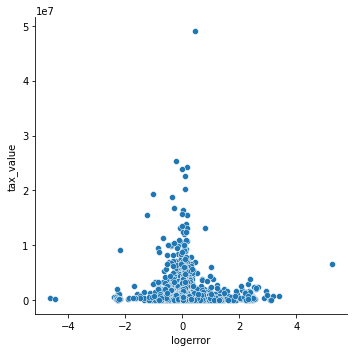

In [8]:
sns.relplot(data=zillow, x='logerror', y='tax_value')

<AxesSubplot:>

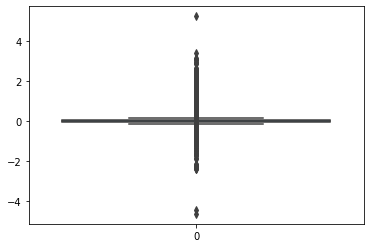

In [9]:
sns.boxplot(data=(zillow.logerror))

In [10]:
zillow[zillow.logerror < -2].head()

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,rawcensustractandblock,zip,logerror,yearbuilt,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt
4660,2.5,3.0,6.0,1969.0,6059.0,4300.0,6.059042e+07,96961.0,-2.330162,1989.0,282747.0,456423.0,173676.0
9536,2.0,4.0,6.0,1488.0,6037.0,2250.0,6.037202e+07,96013.0,-4.655420,1982.0,72486.0,362435.0,289949.0
12230,2.0,3.0,6.0,1732.0,6111.0,7709.0,6.111002e+07,97083.0,-2.175949,1958.0,150068.0,230860.0,80792.0
21935,2.5,3.0,6.0,2475.0,6059.0,7664.0,6.059022e+07,97037.0,-2.236482,2004.0,308221.0,841000.0,532779.0
28443,3.0,4.0,6.0,3441.0,6059.0,7800.0,6.059042e+07,96987.0,-2.267302,1989.0,461577.0,1401664.0,940087.0


In [11]:
len(zillow[zillow.logerror < -2])

24

In [12]:
zillow[zillow.logerror > 2].head(3)

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,rawcensustractandblock,zip,logerror,yearbuilt,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt
580,8.0,7.0,9.0,5906.0,6037.0,23020.0,6.037262e+07,96030.0,5.262999,1952.0,950241.0,6620375.0,5670134.0
629,3.0,4.0,6.0,2367.0,6059.0,3000.0,6.059052e+07,96962.0,2.300450,1969.0,139373.0,636200.0,496827.0
4784,1.0,2.0,4.0,642.0,6037.0,6737.0,6.037312e+07,96437.0,2.304354,1937.0,12813.0,49236.0,36423.0


In [13]:
len(zillow[zillow.logerror < -0.5])

247

In [14]:
len(zillow[zillow.logerror > 2])

87

In [15]:
len(zillow[zillow.logerror > 0.5])

613

In [16]:
#zillow.isnull().sum()

In [17]:
zillow_wrangle.rfe((zillow.drop(columns={'logerror'})), zillow[['logerror']], 10)

(Index(['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips',
        'rawcensustractandblock', 'yearbuilt', 'structuretaxvaluedollarcnt',
        'tax_value', 'landtaxvaluedollarcnt'],
       dtype='object'),
    bathrooms  bedrooms  bldg_quality  f_sqft    fips  rawcensustractandblock  \
 0        3.5       4.0           6.0  3100.0  6059.0            6.059063e+07   
 1        1.0       2.0           6.0  1465.0  6111.0            6.111001e+07   
 2        2.0       3.0           6.0  1243.0  6059.0            6.059022e+07   
 
    yearbuilt  structuretaxvaluedollarcnt  tax_value  landtaxvaluedollarcnt  
 0     1998.0                    485713.0  1023282.0               537569.0  
 1     1967.0                     88000.0   464000.0               376000.0  
 2     1962.0                     85289.0   564778.0               479489.0  )

for col in zillow:
    test(zillow, col, 'logerror')

zillow_wrangle.test(zillow, 'tax_value', 'logerror')

bathrooms, bedrooms, f_sqft

In [18]:
def scale_split(df, columns, target, return_scaler=False):
    
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=0.2, random_state=217)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=217)

    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = pd.DataFrame(train[target])

    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = pd.DataFrame(validate[target])

    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = pd.DataFrame(test[target])

    # make copies
    X_train_scaled = X_train.copy()
    X_validate_scaled = X_validate.copy()
    X_test_scaled = X_test.copy()
    # Make the scaler
    scaler = MinMaxScaler()
    # Fit it
    scaler.fit(train[columns])
    # Apply the scaler:
    X_train_scaled[columns] = pd.DataFrame(scaler.transform(X_train[columns]),
                                                  columns=X_train[columns].columns.values).set_index([X_train.index.values])
                                                  
    X_validate_scaled[columns] = pd.DataFrame(scaler.transform(X_validate[columns]),
                                                  columns=X_validate[columns].columns.values).set_index([X_validate.index.values])
    
    X_test_scaled[columns] = pd.DataFrame(scaler.transform(X_test[columns]),
                                                 columns=X_test[columns].columns.values).set_index([X_test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test

In [19]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = scale_split(zillow, zillow.drop(columns={'logerror'}).columns, 'logerror')

In [20]:
X_train_scaled

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,rawcensustractandblock,zip,yearbuilt,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt
20259,0.153846,0.250000,0.272727,0.042292,0.000000,0.000786,0.004139,0.001673,0.550725,0.011272,0.012630,0.012162
25138,0.192308,0.250000,0.454545,0.087702,0.297297,0.001114,0.297326,0.003563,0.231884,0.012952,0.019710,0.021550
32049,0.153846,0.333333,0.454545,0.066511,1.000000,0.000869,0.999941,0.003695,0.724638,0.021673,0.016531,0.012023
36120,0.153846,0.250000,0.454545,0.058025,0.000000,0.000916,0.010819,0.004396,0.565217,0.011328,0.005313,0.001453
63514,0.230769,0.250000,0.636364,0.087840,0.000000,0.000640,0.000319,0.001548,0.608696,0.020835,0.012981,0.007313
...,...,...,...,...,...,...,...,...,...,...,...,...
77174,0.153846,0.250000,0.454545,0.058484,0.000000,0.000805,0.004162,0.001679,0.594203,0.012099,0.011634,0.010244
56290,0.076923,0.166667,0.272727,0.040686,0.000000,0.000722,0.005882,0.000471,0.456522,0.013006,0.011841,0.010037
34001,0.153846,0.250000,0.454545,0.045502,0.000000,0.001039,0.007444,0.000596,0.565217,0.016043,0.031570,0.037123
10207,0.153846,0.250000,0.272727,0.053667,0.000000,0.000614,0.005882,0.000471,0.355072,0.010639,0.005971,0.002799


In [21]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

In [22]:
X_train_scaled.columns

Index(['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips', 'lot_size',
       'rawcensustractandblock', 'zip', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt'],
      dtype='object')

In [23]:
cluster_vars=['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']
loc_cluster = ['fips', 'rawcensustractandblock', 'zip']#, 'latitude', 'longitude'
h_vars = ['bedrooms', 'bathrooms', 'f_sqft', 'bldg_quality']

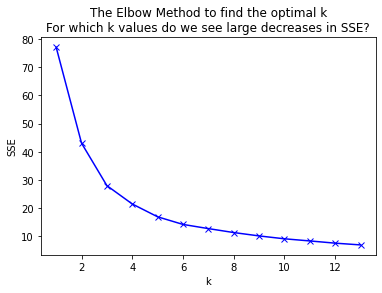

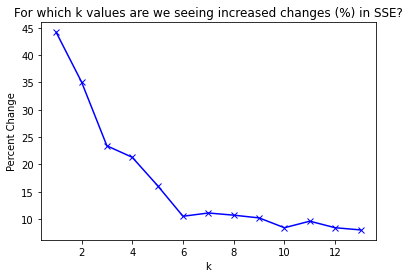

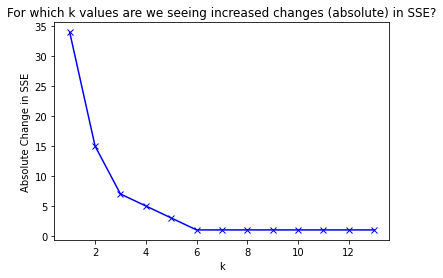

,k,sse,delta,pct_delta
0,1,77.157459,34.0,44.2
1,2,43.038505,15.0,35.1
2,3,27.928909,7.0,23.4
3,4,21.402860,5.0,21.3
4,5,16.837102,3.0,16.1
5,6,14.131081,1.0,10.5
6,7,12.645329,1.0,11.1
7,8,11.240857,1.0,10.7
8,9,10.041088,1.0,10.2
9,10,9.016686,1.0,8.4


In [24]:
find_k(X_train_scaled, cluster_vars, range(1,15))

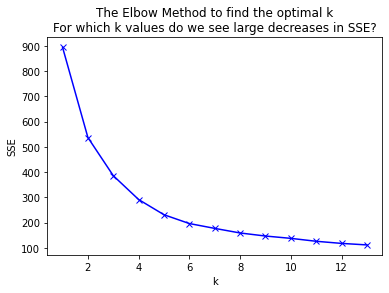

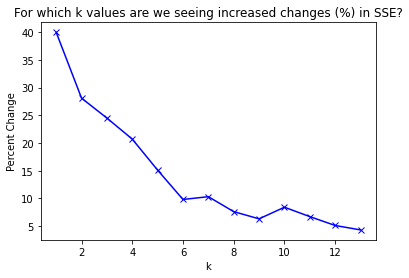

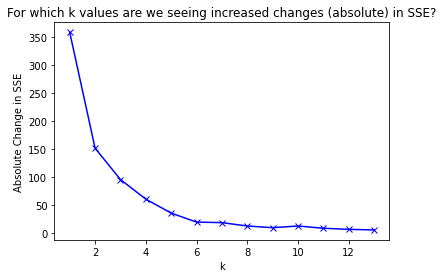

,k,sse,delta,pct_delta
0,1,894.612286,358.0,40.0
1,2,536.967755,151.0,28.1
2,3,385.990392,95.0,24.5
3,4,291.481959,60.0,20.7
4,5,231.254519,35.0,15.1
5,6,196.373199,19.0,9.8
6,7,177.214415,18.0,10.3
7,8,159.044391,12.0,7.6
8,9,146.929013,9.0,6.3
9,10,137.729310,12.0,8.4


In [25]:
find_k(X_train_scaled, h_vars, range(1,15))

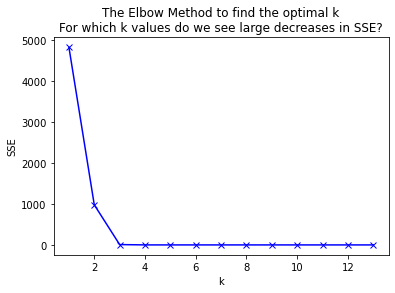

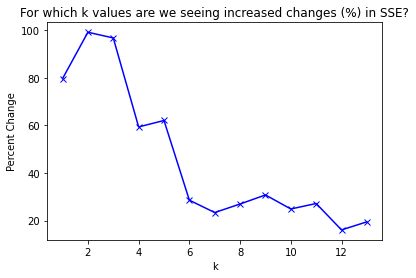

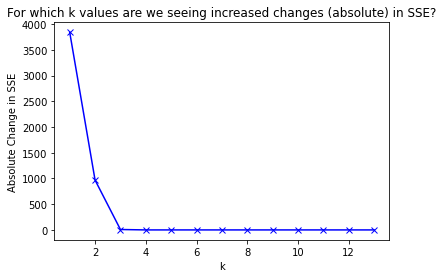

,k,sse,delta,pct_delta
0,1,4820.910237,3844.0,79.7
1,2,977.360948,969.0,99.2
2,3,8.237578,8.0,96.8
3,4,0.261457,0.0,59.4
4,5,0.106100,0.0,62.1
5,6,0.040173,0.0,28.6
6,7,0.028693,0.0,23.4
7,8,0.021979,0.0,27.0
8,9,0.016051,0.0,30.8
9,10,0.011101,0.0,24.9


In [26]:
find_k(X_train_scaled, loc_cluster, range(1,15))

In [27]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])
X_train_scaled['c_cluster'] = kmeans.predict(X_train_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])

In [28]:
X_validate_scaled['c_cluster'] = kmeans.predict(X_validate_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])
X_test_scaled['c_cluster'] = kmeans.predict(X_test_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])

'structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt', 'taxamount'

In [29]:
X_train_scaled.c_cluster.value_counts()

0    26363
2     2829
1      174
Name: c_cluster, dtype: int64

'bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips',
'heatingorsystemtypeid', 'latitude', 'longitude', 'lot_size',
'rawcensustractandblock', 'zip', 'roomcnt', 'unitcnt', 'yearbuilt',
'numberofstories', 'structuretaxvaluedollarcnt', 'tax_value',
'landtaxvaluedollarcnt', 'taxamount', 'month'

In [30]:
#sns.pairplot(data = X_train_scaled, hue = 'tax_cluster', 
#             x_vars = ['latitude', 'longitude','zip', 'fips', 'month', 'unitcnt', 'lot_size'],
#             y_vars = ['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'heatingorsystemtypeid', 'taxamount', 'tax_value'])

In [31]:
def rmse(y_train, y_validate, target):
# 1. Predict value_pred_mean
    value_pred_mean = y_train[target].mean()
    y_train['pred_mean'] = value_pred_mean
    y_validate['pred_mean'] = value_pred_mean

# 2. compute value_pred_median
    pred_median = y_train[target].median()
    y_train['pred_median'] = pred_median
    y_validate['pred_median'] = pred_median

# 3. RMSE of value_pred_mean
    mean_rmse_train = mean_squared_error(y_train[target], y_train.pred_mean)**0.5
    mean_rmse_validate = mean_squared_error(y_validate[target], y_validate.pred_mean)**0.5

    # 4. RMSE of value_pred_median
    median_rmse_train = mean_squared_error(y_train[target], y_train.pred_median)**0.5
    median_rmse_validate = mean_squared_error(y_validate[target], y_validate.pred_median)**0.5
    
    print('\033[1m' + "\u0332".join('RMSE') + '\033[0m')
    print()
    print('\033[1m' + 'Using Mean:'+ '\033[0m')
    print(f'Train(In-Sample):        {round(mean_rmse_train, 4)}') 
    print(f'Validate(Out-of-Sample): {round(mean_rmse_validate, 4)}')
    print()
    print('\033[1m' + 'Using Median:'+ '\033[0m')
    print(f'Train(In-Sample):        {round(median_rmse_train, 4)}') 
    print(f'Validate(Out-of-Sample): {round(median_rmse_validate, 4)}')

In [32]:
rmse(y_train, y_validate, 'logerror')

R̲M̲S̲E

Using Mean:
Train(In-Sample):        0.1795
Validate(Out-of-Sample): 0.1654

Using Median:
Train(In-Sample):        0.1799
Validate(Out-of-Sample): 0.1657


In [91]:
def pf(X_train, y_train, X_validate, y_validate, X_test, y_test, target, n):
# make the polynomial features to get a new set of features
    n=n
    pf = PolynomialFeatures(degree=n)

# fit and transform X_train_scaled
    X_train_degree = pf.fit_transform(X_train)

# transform X_validate & X_test
    X_validate_degree = pf.transform(X_validate)
    X_test_degree = pf.transform(X_test)

## **LinearRegression**
# create the model object
    lm = LinearRegression(normalize=True)

# fit 
    lm.fit(X_train_degree, y_train[target])

# predict and use train
    y_train['pred_lm'] = lm.predict(X_train_degree)

# evaluate: rmse
    rmse_train = mean_squared_error(y_train[target], y_train.pred_lm) ** (1/2)

# predict validate
    y_validate['pred_lm'] = lm.predict(X_validate_degree)

# evaluate: rmse
    rmse_validate = mean_squared_error(y_validate[target], y_validate.pred_lm) ** (1/2)
    
# Predict Test
    y_test['pred_lm'] = lm.predict(X_test_degree)
    lm_rmse_test = mean_squared_error(y_test[target], y_test.pred_lm) ** (1/2)

    print('\033[1m' + '\u0332'.join('OLS using LinearRegression')+ '\033[0m')
    print()
    print(f'RMSE for Training/In-Sample:        {round(rmse_train, 4)}')
    print(f'RMSE for Validation/Out-of-Sample:  {round(rmse_validate, 4)}')
    print(f'R^2 Validate:                       {round(explained_variance_score(y_validate[target], y_validate.pred_lm), 4)}')

In [92]:
pf(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'logerror', 1)

O̲L̲S̲ ̲u̲s̲i̲n̲g̲ ̲L̲i̲n̲e̲a̲r̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

RMSE for Training/In-Sample:        0.0911
RMSE for Validation/Out-of-Sample:  0.093
R^2 Validate:                       0.006


In [35]:
def lasso_lars(X_train, y_train, X_validate, y_validate, X_test, y_test, target, n):
# create the model object
    lars = LassoLars(alpha=n)

# fit the model to our training data.
    lars.fit(X_train, y_train[target])

# predict train
    y_train['pred_lars'] = lars.predict(X_train)

# evaluate: rmse
    lars_rmse_train = mean_squared_error(y_train[target], y_train.pred_lars) ** 0.5

# predict validate
    y_validate['pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
    lars_rmse_validate = mean_squared_error(y_validate[target], y_validate.pred_lars) ** 0.5
    
    print('\033[1m' + '\u0332'.join('Lasso + Lars')+ '\033[0m')
    print()
    print(f'RMSE for Training/In-Sample:        {round(lars_rmse_train, 4)}')
    print(f'RMSE for Validation/Out-of-Sample:  {round(lars_rmse_validate, 4)}')
    print(f'R^2 Validate:                       {round(explained_variance_score(y_validate[target], y_validate.pred_lars), 3)}')

In [36]:
lasso_lars(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'logerror', 0)

L̲a̲s̲s̲o̲ ̲+̲ ̲L̲a̲r̲s

RMSE for Training/In-Sample:        0.179
RMSE for Validation/Out-of-Sample:  0.1649
R^2 Validate:                       0.006


In [37]:
def glm(X_train, y_train, X_validate, y_validate, X_test, y_test, target, p, a):
# create the model object
    glm = TweedieRegressor(power=p, alpha=a)

# fit the model to our training data. 
    glm.fit(X_train, y_train[target])

# predict train
    y_train['pred_glm'] = glm.predict(X_train)

# evaluate: rmse
    glm_rmse_train = mean_squared_error(y_train[target], y_train.pred_glm) ** 0.5

# predict validate
    y_validate['pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
    glm_rmse_validate = mean_squared_error(y_validate[target], y_validate.pred_glm) ** 0.5
    
    print('\033[1m' + '\u0332'.join('GLM using Tweedie')+ '\033[0m')
    print()
    print(f'RMSE for Training/In-Sample:        {round(glm_rmse_train, 4)}')
    print(f'RMSE for Validation/Out-of-Sample:  {round(glm_rmse_validate, 4)}')
    print(f'R^2 Validate:                       {round(explained_variance_score(y_validate[target], y_validate.pred_glm), 3)}')

In [38]:
glm(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'logerror', 0, 0)

G̲L̲M̲ ̲u̲s̲i̲n̲g̲ ̲T̲w̲e̲e̲d̲i̲e

RMSE for Training/In-Sample:        0.1791
RMSE for Validation/Out-of-Sample:  0.165
R^2 Validate:                       0.005


In [39]:
y_train.describe()

,logerror,pred_mean,pred_median,pred_lm,pred_lars,pred_glm
count,29366.000000,2.936600e+04,2.936600e+04,29366.000000,29366.000000,29366.000000
mean,0.019606,1.960640e-02,7.204133e-03,0.019606,0.019606,0.019646
std,0.179479,1.224736e-15,3.836406e-15,0.012837,0.012456,0.010679
min,-4.453964,1.960640e-02,7.204133e-03,-0.130639,-0.131030,-0.024417
25%,-0.024394,1.960640e-02,7.204133e-03,0.012139,0.012200,0.013197
50%,0.007204,1.960640e-02,7.204133e-03,0.017900,0.017804,0.018073
75%,0.041167,1.960640e-02,7.204133e-03,0.025676,0.025496,0.025164
max,5.262999,1.960640e-02,7.204133e-03,0.205025,0.200487,0.139326


In [40]:
def no_error(y_validate):
    # Plot
    plt.figure(figsize=(16,5))
    plt.scatter(y_validate.logerror, y_validate.pred_lm, 
                alpha=0.5, color="orange", s=100, label="3rd degree Polynomial")
    plt.plot(y_validate.logerror, y_validate.pred_mean, alpha=.3, color="black", label='_nolegend_')
    plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue")
    plt.scatter(y_validate.logerror, y_validate.pred_glm, 
                 alpha=.2, color="black", s=100, label="Model: TweedieRegressor")
    plt.scatter(y_validate.logerror, y_validate.pred_lars, 
                alpha=.1, color="blue", s=100, label="Lasso-Lars")
    plt.ticklabel_format(style='plain')

    plt.legend()
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("Actual Error")
    plt.ylabel("Predicted Error")
    plt.show()

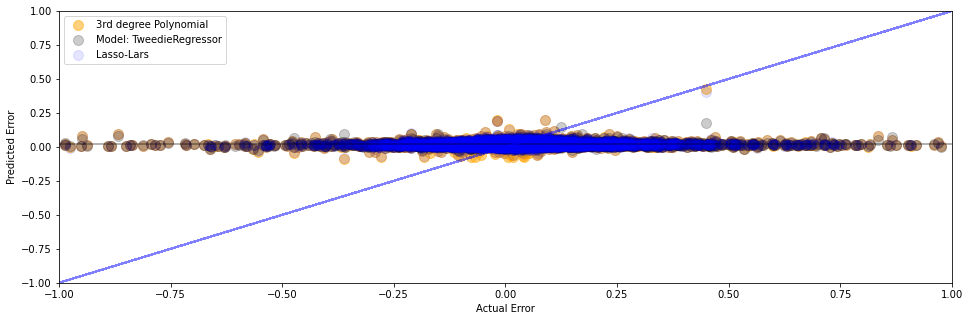

In [41]:
no_error(y_validate)

---

In [42]:
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,77575,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017-09-20,Single Family Residential
77576,77576,261.0,17239384,2968375,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,77610,0.013209,2017-09-21,Single Family Residential
77577,77577,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017-09-21,Single Family Residential
77578,77578,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017-09-25,Single Family Residential


In [43]:
def wz(df):
    random.seed(217)
    df = df[(df.propertylandusedesc == 'Single Family Residential') | 
            (df.propertylandusedesc == 'Inferred Single Family Residential')]
    # Create a new column for month of transaction
    df['month'] = df['transactiondate'].str[5:7]
    df['transactiondate'] = df['transactiondate'].str[:4]
    # Reassign the df to only the values where the home had a transaction in 2017
    df = df[df.transactiondate == '2017']
    parcelid = df.parcelid
    df = df.drop(columns={'parcelid'})
    df.rename(columns={'bedroomcnt':'bedrooms',
                       'bathroomcnt':'bathrooms', 
                       'calculatedfinishedsquarefeet':'f_sqft', 
                       'taxvaluedollarcnt':'tax_value',
                       'lotsizesquarefeet':'lot_size',
                       'regionidzip':'zip',
                       'buildingqualitytypeid':'bldg_quality'}, inplace=True)
    
    df = df[['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips',
             'lot_size','rawcensustractandblock', 'zip', 'yearbuilt','tax_value']]
    
    cols = [col for col in df.columns if col not in ['month', 'fips']]
    # Remove outliers 
    #df = remove_outliers(df, 1.5, df[cols])
    df.bldg_quality.fillna(6.0,inplace=True)# Median/Mode 18701 values
    df.f_sqft.fillna(1659.0,inplace=True)# values
    df.lot_size.fillna(6840.5,inplace=True)# values
    df.zip.fillna(96412.0,inplace=True)# 26 values
    df.yearbuilt.fillna(1961.0,inplace=True)# Median, 116 values
    df.tax_value.fillna(373612.0,inplace=True)# Median, 1 value
   
    return df

In [44]:
zillow = wz(zillow)

In [45]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = scale_split(zillow, zillow.drop(columns={'tax_value'}).columns, 'tax_value')

In [46]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train_scaled[['fips', 'rawcensustractandblock', 'zip']])
X_train_scaled['loc_cluster'] = kmeans.predict(X_train_scaled[['fips', 'rawcensustractandblock', 'zip']])

In [47]:
X_validate_scaled['loc_cluster'] = kmeans.predict(X_validate_scaled[['fips', 'rawcensustractandblock', 'zip']])
X_test_scaled['loc_cluster'] = kmeans.predict(X_test_scaled[['fips', 'rawcensustractandblock', 'zip']])

In [48]:
rmse(y_train, y_validate, 'tax_value')

R̲M̲S̲E

Using Mean:
Train(In-Sample):        707738.9781
Validate(Out-of-Sample): 871651.4959

Using Median:
Train(In-Sample):        724811.9758
Validate(Out-of-Sample): 886325.3928


In [49]:
pf(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'tax_value', 2)

O̲L̲S̲ ̲u̲s̲i̲n̲g̲ ̲L̲i̲n̲e̲a̲r̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

RMSE for Training/In-Sample:        493554
RMSE for Validation/Out-of-Sample:  608237
R^2 Validate:                       0.513


In [50]:
glm(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'tax_value', 0, 0)

G̲L̲M̲ ̲u̲s̲i̲n̲g̲ ̲T̲w̲e̲e̲d̲i̲e

RMSE for Training/In-Sample:        532730.6812
RMSE for Validation/Out-of-Sample:  703595.3132
R^2 Validate:                       0.349


In [55]:
lasso_lars(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'tax_value', 0)

L̲a̲s̲s̲o̲ ̲+̲ ̲L̲a̲r̲s

RMSE for Training/In-Sample:        532565.9915
RMSE for Validation/Out-of-Sample:  703711.4212
R^2 Validate:                       0.348


In [51]:
def pf_test(X_train, y_train, X_test, y_test, target, n):
    n=n
    pf = PolynomialFeatures(degree=n)

    X_train_degree = pf.fit_transform(X_train)
    X_test_degree = pf.transform(X_test)
    # create the model object
    lm = LinearRegression(normalize=True)

# fit 
    lm.fit(X_train_degree, y_train[target])
    
    
    
    # Predict Test
    y_test['pred_lm'] = lm.predict(X_test_degree)
    lm_rmse_test = mean_squared_error(y_test[target], y_test.pred_lm) ** (1/2)
    print(f'RMSE for Test:  {round(lm_rmse_test)}')
    print(f'R^2 Test:        {round(explained_variance_score(y_test.tax_value, y_test.pred_lm), 3)}')

In [52]:
pf_test(X_train_scaled, y_train, X_test_scaled, y_test, 'tax_value', 2)

RMSE for Test:  524425
R^2 Test:        0.463


In [66]:
def no_e(y_validate):
    # Plot
    plt.figure(figsize=(16,5))
    plt.scatter(y_validate.tax_value, y_validate.pred_lm, 
                alpha=0.5, color="orange", s=100, label="3rd degree Polynomial")
    plt.plot(y_validate.tax_value, y_validate.pred_mean, alpha=.3, color="black", label='_nolegend_')
    plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue")
    plt.scatter(y_validate.tax_value, y_validate.pred_glm, 
                 alpha=.2, color="black", s=100, label="Model: TweedieRegressor")
    plt.scatter(y_validate.tax_value, y_validate.pred_lars, 
                alpha=.1, color="blue", s=100, label="Lasso-Lars")
    plt.ticklabel_format(style='plain')
    plt.legend()
    plt.xlim(-100000,10000000)
    plt.ylim(-1000000,10000000)
    plt.xlabel("Actual Error")
    plt.ylabel("Predicted Error")
    plt.show()

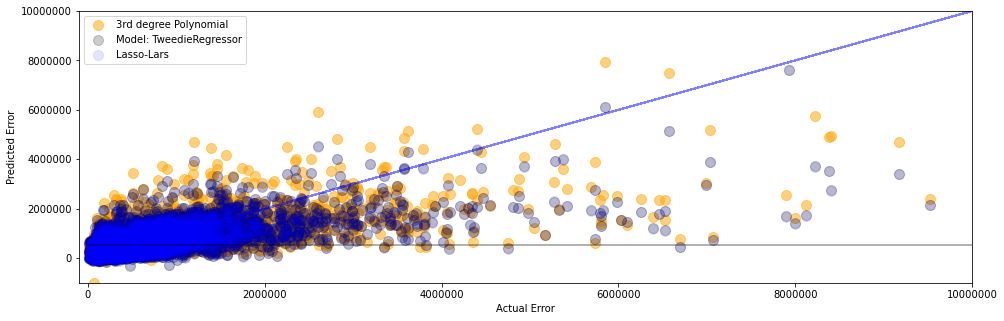

In [67]:
no_e(y_validate)

---

In [70]:
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,77575,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017-09-20,Single Family Residential
77576,77576,261.0,17239384,2968375,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,77610,0.013209,2017-09-21,Single Family Residential
77577,77577,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017-09-21,Single Family Residential
77578,77578,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017-09-25,Single Family Residential


In [71]:
def wz1(df):
    random.seed(217)
    df = df[(df.propertylandusedesc == 'Single Family Residential') | 
            (df.propertylandusedesc == 'Inferred Single Family Residential')]
    # Create a new column for month of transaction
    df['month'] = df['transactiondate'].str[5:7]
    df['transactiondate'] = df['transactiondate'].str[:4]
    # Reassign the df to only the values where the home had a transaction in 2017
    df = df[df.transactiondate == '2017']
    parcelid = df.parcelid
    df = df.drop(columns={'parcelid'})
    df.rename(columns={'bedroomcnt':'bedrooms',
                       'bathroomcnt':'bathrooms', 
                       'calculatedfinishedsquarefeet':'f_sqft', 
                       'taxvaluedollarcnt':'tax_value',
                       'lotsizesquarefeet':'lot_size',
                       'regionidzip':'zip',
                       'buildingqualitytypeid':'bldg_quality'}, inplace=True)
    
    df = df[['bathrooms', 'bedrooms', 'bldg_quality', 'f_sqft', 'fips',
             'lot_size','rawcensustractandblock', 'zip', 'logerror',
             'yearbuilt', 'structuretaxvaluedollarcnt','tax_value', 
             'landtaxvaluedollarcnt']]#'month', 'numberofstories', 'unitcnt', taxamount, 'latitude', 'longitude'
    df = df[(df.logerror < 0.5) & (df.logerror > -0.5)]
    cols = [col for col in df.columns if col not in ['month', 'fips']]
    # Remove outliers 
    #df = remove_outliers(df, 1.5, df[cols])
    df.bldg_quality.fillna(6.0,inplace=True)# Median/Mode 18701 values
    df.f_sqft.fillna(1659.0,inplace=True)# values
    #df.heatingorsystemtypeid.fillna(2.0,inplace=True)# values
    df.lot_size.fillna(6840.5,inplace=True)# values
    df.zip.fillna(96412.0,inplace=True)# 26 values
    #df.unitcnt.fillna(1.0,inplace=True)# 18594 values
    df.yearbuilt.fillna(1961.0,inplace=True)# Median, 116 values
    #df.numberofstories.fillna(1.0,inplace=True)# Median/Mode, 37880 values
    df.structuretaxvaluedollarcnt.fillna(131811.0,inplace=True)# 84 values
    df.tax_value.fillna(373612.0,inplace=True)# Median, 1 value
    df.landtaxvaluedollarcnt.fillna(218032.0,inplace=True)# Median, 1 value
    #df.taxamount.fillna(4647.74,inplace=True)# Median, 4 values
   
    return df

In [72]:
zillow = wz1(zillow)

In [73]:
zillow.describe()

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,rawcensustractandblock,zip,logerror,yearbuilt,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt
count,51581.000000,51581.000000,51581.000000,51581.000000,51581.000000,5.158100e+04,5.158100e+04,51581.000000,51581.000000,51581.000000,5.158100e+04,5.158100e+04,5.158100e+04
mean,2.300605,3.303348,6.174056,1920.911324,6049.174909,1.105987e+04,6.049486e+07,96632.180842,0.010708,1963.542642,1.959559e+05,5.266320e+05,3.308776e+05
std,1.015465,0.942085,1.379975,991.941789,21.076471,8.065704e+04,2.091596e+05,4445.885369,0.091563,23.043458,2.499638e+05,7.348184e+05,5.565985e+05
min,0.000000,0.000000,1.000000,128.000000,6037.000000,2.360000e+02,6.037101e+07,95982.000000,-0.497263,1878.000000,1.480000e+02,1.000000e+03,1.610000e+02
25%,2.000000,3.000000,6.000000,1270.000000,6037.000000,5.599000e+03,6.037401e+07,96208.000000,-0.024528,1950.000000,7.751200e+04,1.950430e+05,7.658000e+04
50%,2.000000,3.000000,6.000000,1659.000000,6037.000000,6.840500e+03,6.037620e+07,96414.000000,0.006599,1961.000000,1.319130e+05,3.744840e+05,2.184480e+05
75%,3.000000,4.000000,7.000000,2304.000000,6059.000000,8.750000e+03,6.059042e+07,96995.000000,0.039095,1979.000000,2.260590e+05,6.180000e+05,4.075080e+05
max,18.000000,14.000000,12.000000,21929.000000,6111.000000,6.971010e+06,6.111009e+07,399675.000000,0.497845,2016.000000,9.164901e+06,4.906124e+07,4.895220e+07


In [74]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = scale_split(zillow, zillow.drop(columns={'logerror'}).columns, 'logerror')

In [75]:
cluster_vars=['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']
loc_cluster = ['fips', 'rawcensustractandblock', 'zip']#, 'latitude', 'longitude'
h_vars = ['bedrooms', 'bathrooms', 'f_sqft', 'bldg_quality']

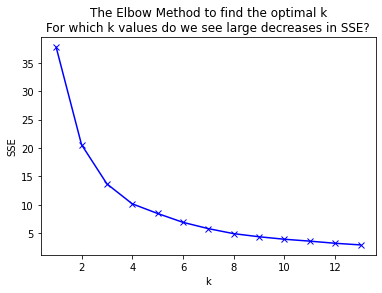

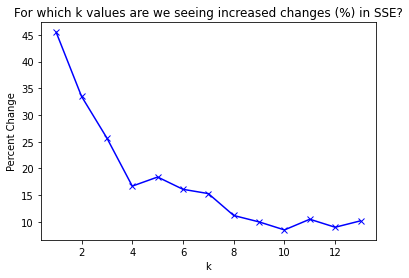

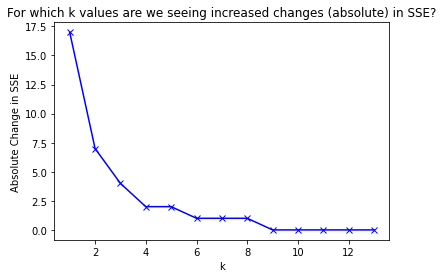

,k,sse,delta,pct_delta
0,1,37.750418,17.0,45.5
1,2,20.587770,7.0,33.5
2,3,13.683292,4.0,25.7
3,4,10.165505,2.0,16.7
4,5,8.465045,2.0,18.4
5,6,6.905651,1.0,16.1
6,7,5.796832,1.0,15.3
7,8,4.912751,1.0,11.2
8,9,4.364881,0.0,10.0
9,10,3.926845,0.0,8.5


In [76]:
find_k(X_train_scaled, cluster_vars, range(1,15))

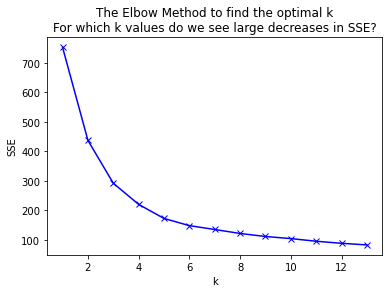

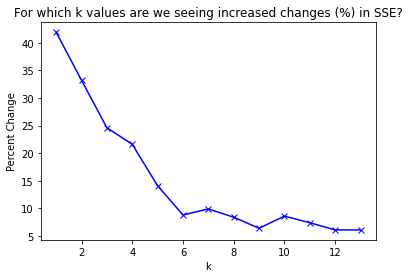

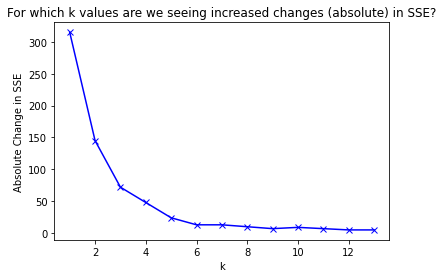

,k,sse,delta,pct_delta
0,1,752.926627,315.0,41.9
1,2,437.441913,145.0,33.2
2,3,292.244629,72.0,24.6
3,4,220.438858,48.0,21.6
4,5,172.874161,24.0,14.1
5,6,148.471893,13.0,8.8
6,7,135.369258,13.0,9.9
7,8,121.929508,10.0,8.4
8,9,111.679644,7.0,6.4
9,10,104.558244,9.0,8.6


In [77]:
find_k(X_train_scaled, h_vars, range(1,15))

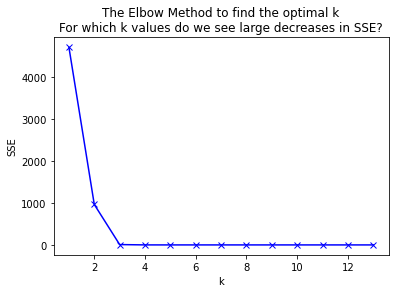

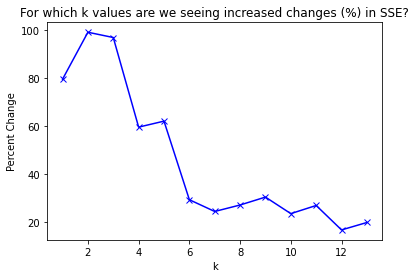

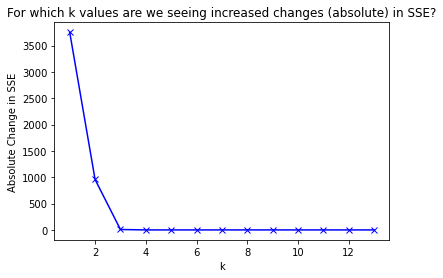

,k,sse,delta,pct_delta
0,1,4720.137555,3754.0,79.5
1,2,965.965111,958.0,99.1
2,3,8.233284,8.0,96.9
3,4,0.257360,0.0,59.5
4,5,0.104208,0.0,62.0
5,6,0.039550,0.0,29.2
6,7,0.028018,0.0,24.3
7,8,0.021196,0.0,27.0
8,9,0.015483,0.0,30.3
9,10,0.010788,0.0,23.4


In [78]:
find_k(X_train_scaled, loc_cluster, range(1,15))

In [79]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])
X_train_scaled['cluster'] = kmeans.predict(X_train_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])

In [80]:
X_validate_scaled['cluster'] = kmeans.predict(X_validate_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])
X_test_scaled['cluster'] = kmeans.predict(X_test_scaled[['structuretaxvaluedollarcnt', 'tax_value', 'landtaxvaluedollarcnt']])

In [81]:
rmse(y_train, y_validate, 'logerror')

R̲M̲S̲E

Using Mean:
Train(In-Sample):        0.0914
Validate(Out-of-Sample): 0.0933

Using Median:
Train(In-Sample):        0.0915
Validate(Out-of-Sample): 0.0933


In [93]:
pf(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'logerror', 1)

O̲L̲S̲ ̲u̲s̲i̲n̲g̲ ̲L̲i̲n̲e̲a̲r̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

RMSE for Training/In-Sample:        0.0911
RMSE for Validation/Out-of-Sample:  0.093
R^2 Validate:                       0.006


In [83]:
glm(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'logerror', 0, 0)

G̲L̲M̲ ̲u̲s̲i̲n̲g̲ ̲T̲w̲e̲e̲d̲i̲e

RMSE for Training/In-Sample:        0.0911
RMSE for Validation/Out-of-Sample:  0.093
R^2 Validate:                       0.005


In [86]:
lasso_lars(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'logerror', 0)

L̲a̲s̲s̲o̲ ̲+̲ ̲L̲a̲r̲s

RMSE for Training/In-Sample:        0.0911
RMSE for Validation/Out-of-Sample:  0.093
R^2 Validate:                       0.006


In [84]:
def pf_test(X_train, y_train, X_test, y_test, target, n):
    n=n
    pf = PolynomialFeatures(degree=n)

    X_train_degree = pf.fit_transform(X_train)
    X_test_degree = pf.transform(X_test)
    # create the model object
    lm = LinearRegression(normalize=True)

# fit 
    lm.fit(X_train_degree, y_train[target])
    
    # Predict Test
    y_test['pred_lm'] = lm.predict(X_test_degree)
    lm_rmse_test = mean_squared_error(y_test[target], y_test.pred_lm) ** (1/2)
    print(f'RMSE for Test:  {round(lm_rmse_test)}')
    print(f'R^2 Test:        {round(explained_variance_score(y_test.tax_value, y_test.pred_lm), 3)}')